<a href="https://colab.research.google.com/github/UsmanShafeeq/Advanced-Machine-Learning-Project/blob/main/DNS_Spoofing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect DNS Spoofing attacks using Machine Learning based on network traffic flow features

In [1]:
!pip install imbalanced-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


# 2️⃣ Load Dataset

In [3]:
df = pd.read_csv("/content/DNS_Spoofing.pcap.csv")

In [4]:
df.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance
0,10.4,17,63.6,6427.067116,0.0,0.0,0.0,0.1,0.1,0.0,...,1.0,6391.0,140.0,1074.0,639.1,296.700541,639.1,0.000156,10.0,88031.211111
1,8.0,17,64.0,2434.868222,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6989.0,46.0,1074.0,698.9,343.381696,698.9,0.000655,10.0,117910.988889
2,9.2,17,59.8,1138.951828,0.0,0.0,0.0,0.1,0.1,0.0,...,1.0,4387.0,46.0,1074.0,438.7,483.072585,438.7,0.000955,10.0,233359.122222
3,8.0,17,50.0,4520.698426,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7859.0,362.0,1074.0,785.9,259.964292,785.9,0.000221,10.0,67581.433333
4,8.0,17,51.4,1231.988251,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6164.0,356.0,796.0,616.4,217.480625,616.4,0.000851,10.0,47297.822222


In [5]:
df.shape

(35469, 39)

# 3️⃣ Data Cleaning

In [6]:
df.isnull().sum()

,0
Header_Length,0
Protocol Type,0
Time_To_Live,0
Rate,0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0
psh_flag_number,0
ack_flag_number,0
ece_flag_number,0


In [7]:
df = df.drop_duplicates()


In [8]:
df.shape

(35269, 39)

In [9]:
df = df.fillna(df.median(numeric_only=True))


In [10]:
print(df.columns)


Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance'],
      dtype='object')


# 4️⃣ Features and Labels

In [11]:
df["label"] = 0  # normal by default

df.loc[
    (df["Rate"] > 5000) &
    (df["Variance"] > 50000) &
    (df["IAT"] < 0.001),
    "label"
] = 1


In [12]:
X = df.drop("label", axis=1)
y = df["label"]


# 5️⃣ Feature Scaling

In [13]:
import numpy as np

# Replace inf and -inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Check how many NaNs now
print(X.isnull().sum().sort_values(ascending=False).head(10))

# Fill NaN with median (safe for network data)
X = X.fillna(X.median())

Header_Length      0
Protocol Type      0
Time_To_Live       0
Rate               0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
dtype: int64


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaling successful!")

Scaling successful!


# 6️⃣ Handle Class Imbalance (SMOTE)

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Before:", y.value_counts())
print("After:", pd.Series(y_resampled).value_counts())


Before: label
0    30799
1     4470
Name: count, dtype: int64
After: label
1    30799
0    30799
Name: count, dtype: int64


# 7️⃣ Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42
)


# ML Models

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


# 9️⃣ Train and Evaluate All Models

In [18]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print("="*60)
    print(f"Model: {name}")
    print("Accuracy:", acc)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Model: Logistic Regression
Accuracy: 0.9060876623376624
[[5592  558]
 [ 599 5571]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6150
           1       0.91      0.90      0.91      6170

    accuracy                           0.91     12320
   macro avg       0.91      0.91      0.91     12320
weighted avg       0.91      0.91      0.91     12320

Model: KNN
Accuracy: 0.9838474025974026
[[6025  125]
 [  74 6096]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6150
           1       0.98      0.99      0.98      6170

    accuracy                           0.98     12320
   macro avg       0.98      0.98      0.98     12320
weighted avg       0.98      0.98      0.98     12320

Model: SVM
Accuracy: 0.98125
[[6038  112]
 [ 119 6051]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6150
           1       0.98      0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:48:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 🔟 Best Model Selection

In [19]:
best_model = max(results, key=results.get)
print("\nBest Performing Model:", best_model)



Best Performing Model: Random Forest


# 1️⃣1️⃣ Feature Importance (Research Contribution)

Only Random Forest and XGBoost support this:

In [20]:
rf = models["Random Forest"]
importances = rf.feature_importances_

feature_importance = pd.DataFrame({
    "Feature": df.drop("label", axis=1).columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance.head(15))


            Feature  Importance
3              Rate    0.276178
36              IAT    0.251799
15             HTTP    0.076836
38         Variance    0.073316
34              Std    0.052111
16            HTTPS    0.051690
0     Header_Length    0.048676
30          Tot sum    0.029780
33              AVG    0.023757
35         Tot size    0.022355
32              Max    0.019061
8   ack_flag_number    0.015010
31              Min    0.012736
22              TCP    0.010948
23              UDP    0.010910


# 1️⃣ Feature Selection using Mutual Information

In [21]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({
    "Feature": X.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print(mi_df.head(15))


            Feature  MI_Score
3              Rate  0.306723
36              IAT  0.297991
2      Time_To_Live  0.236939
38         Variance  0.217381
35         Tot size  0.216304
34              Std  0.216270
30          Tot sum  0.215936
33              AVG  0.215647
0     Header_Length  0.183235
15             HTTP  0.160907
31              Min  0.160605
32              Max  0.115533
16            HTTPS  0.104343
11        ack_count  0.093350
8   ack_flag_number  0.089500


Now select top features:

In [22]:
top_features = mi_df.head(15)["Feature"].tolist()
X_selected = X[top_features]

# Re-scale again
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


# 2️⃣ PCA Visualization (2D Plot)

This gives a beautiful figure for research paper.

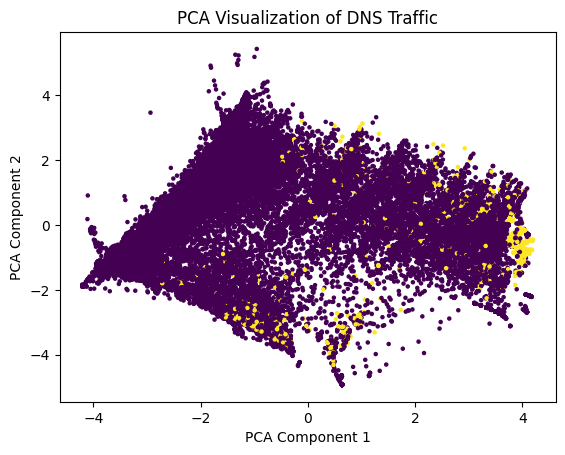

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of DNS Traffic")
plt.show()


# 3️⃣ Hyperparameter Tuning (GridSearchCV on Random Forest)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(rf, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

best_rf = grid.best_estimator_


Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


# 4️⃣ ROC Curves for All Models

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:50:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


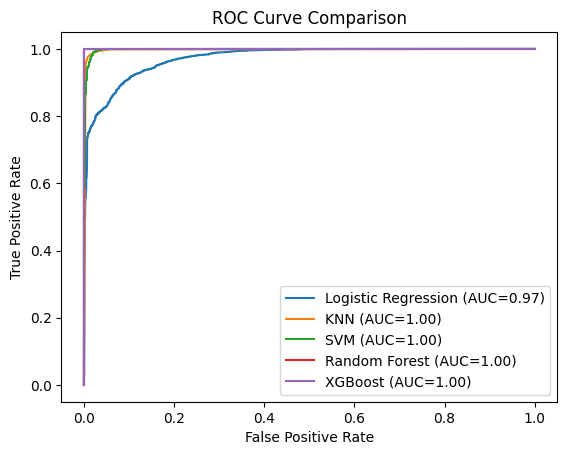

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure()

for name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# 5️⃣ Deep Learning Model (Neural Network IDS)

In [26]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 153.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

loss, acc = model.evaluate(X_test, y_test)
print("Deep Learning Accuracy:", acc)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9060 - loss: 0.2174 - val_accuracy: 0.9860 - val_loss: 0.0417
Epoch 2/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9835 - loss: 0.0512 - val_accuracy: 0.9916 - val_loss: 0.0218
Epoch 3/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9911 - loss: 0.0291 - val_accuracy: 0.9945 - val_loss: 0.0149
Epoch 4/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9920 - loss: 0.0256 - val_accuracy: 0.9957 - val_loss: 0.0112
Epoch 5/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9936 - loss: 0.0183 - val_accuracy: 0.9942 - val_loss: 0.0167
Epoch 6/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9941 - loss: 0.0196 - val_accuracy: 0.9966 - val_loss: 0.0103
Epoch 7/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9948 - loss: 0.0160 - val_accuracy: 0.9960 - val_loss: 0.0107
Epoch 8/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9947 - loss: 0.0186 - val_accurac

# 6️⃣ Confusion Matrix Heatmap

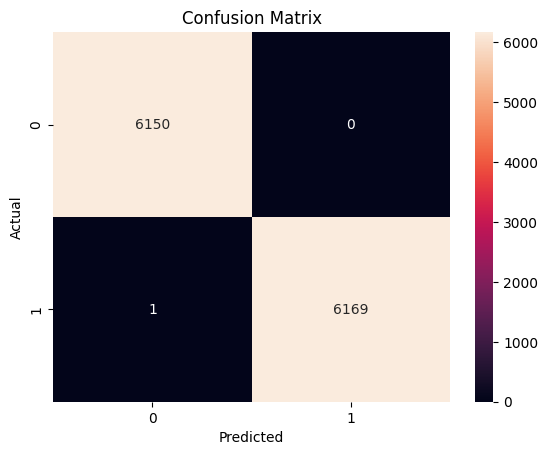

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [29]:
# save model
import joblib
joblib.dump(best_rf, "dns_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [30]:
model = joblib.load("dns_model.pkl")
scaler = joblib.load("scaler.pkl")

def predict(request):
    features = [...]
    scaled = scaler.transform([features])
    pred = model.predict(scaled)
    return JsonResponse({"prediction": int(pred[0])})


# 1️⃣ FastAPI Backend (serves predictions)

In [31]:
! pip install fastapi uvicorn joblib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 6.2 MB/s eta 0:00:00


In [32]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [33]:
!pip install fastapi uvicorn pyngrok joblib nest-asyncio


In [35]:
import nest_asyncio
nest_asyncio.apply()


In [36]:
import joblib
import numpy as np

# Load your saved model and scaler
model = joblib.load("dns_model.pkl")
scaler = joblib.load("scaler.pkl")
